In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

from utils import load_dataset, prepare_dataframe

In [2]:
res, ref = load_dataset()
res = prepare_dataframe(res)
res = res.join(ref, on="img_id")

# prepare folder structure if not existent
if not os.path.exists('figures'):
    os.mkdir('figures')

## Task 1: Gather insights about the annotators.

### a) Gather insights about the annotators

In [3]:
n_annotators = res['user_id'].unique().shape[0]
print(n_annotators)

22


### b) What are the average, min and max annotation times?

We first look at the distribution as it is in the unsanitized data.

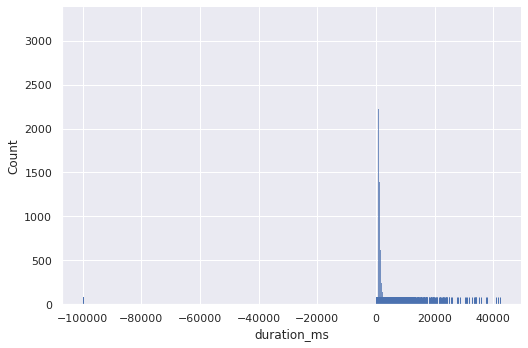

In [4]:
sns.displot(res['duration_ms'], rug=True, bins='fd',aspect=1.5)
plt.savefig('figures/histogram_times_naive.pdf')
plt.show()

So we have some values in the range from -99999 to 0. The negative values are probably the result of an expired timer. Values close to 0, especially below 100ms are probably the result of someone accidentially doubleclicking an answer in the annotation tool. To sanitize the data we exlude those answers.

In [5]:
pos_res = res[res['duration_ms'] > 100]

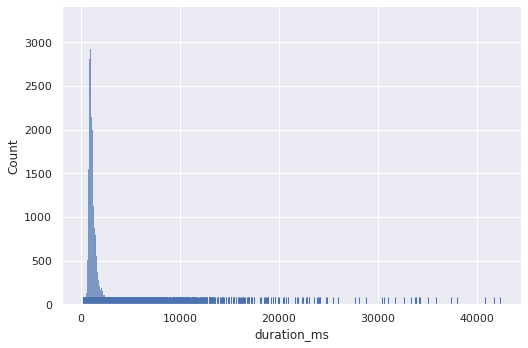

In [6]:
sns.displot(pos_res['duration_ms'], rug=True, bins='fd',aspect=1.5)
plt.savefig('figures/histogram_times_positives.pdf')
plt.show()

Without any further assumption this would be the correct plot, but due to a very small number of comparatively high samples, we can't evaluate the shape of our distribution very well. 
To have a closer look at the actual distribution, we restrict ourselves to the 98th percentile of the data.

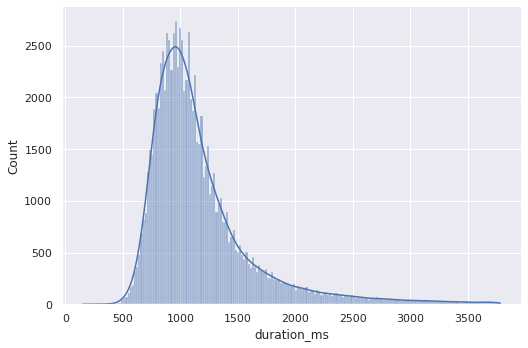

In [7]:
times_98 = pos_res[pos_res['duration_ms'] < np.percentile(pos_res['duration_ms'], 98)]['duration_ms']

sns.displot(times_98, rug=False, kde=True, bins='fd',aspect=1.5)
plt.savefig('figures/histogram_times_positives.pdf')
plt.show()

This does look very well like the poisson-like distribution one would expect in a case like this. 

In [8]:
print('-- stats of total dataset ------------')
times_avg = int(res['duration_ms'].mean())  # no point to use decimals for milliseconds
times_min = res['duration_ms'].min()
times_max = res['duration_ms'].max()
print('avg:', times_avg)
print('min:', times_min)
print('max:', times_max)
print("\n")

avg_98 = int(times_98.mean())
min_98 = times_98.min()
max_98 = times_98.max()
print("-- stats of 98-percintile data -------")
print('avg_98:', avg_98)
print('min_98:', min_98)
print('max_98:', max_98)
print('\n')

-- stats of total dataset ------------
avg: 1284
min: -99999
max: 42398


-- stats of 98-percintile data -------
avg_98: 1176
min_98: 149
max_98: 3782




In the context of answering the given question I would still stick to the total (positive) dataset, since the "outliers" with long durations are probably just resolts of someone beeing ditracted for a moment. We still speak about delays of $<= 40$s, which just happens from time to time and the dataset does indeed represent this fact.  Even the negative ones are probably just the result of an expired timer, since the results of those samples are all reasonable.

### c) Did all annotators produce the same amount of results, or are there differences?

In [9]:
n_annotations = res.groupby("vendor_user_id").count()['created_at']  # just choose a column that is never NaN.
n_annotations = n_annotations.reset_index()
n_annotations = n_annotations.rename(columns={"created_at": "n_annotations"})
# print(n_annotations.mean(), n_annotations.min(), n_annotations.max())

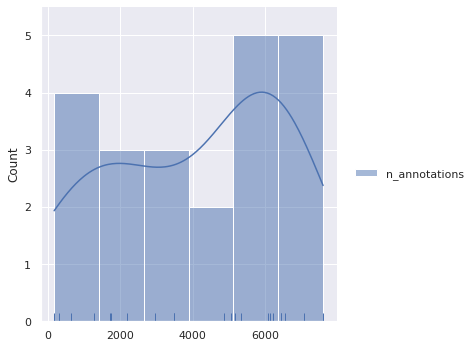

In [10]:
sns.displot(n_annotations, rug=True, kde=True, aspect=1.)
plt.savefig('figures/histogram_annotations_total.pdf')
plt.show()

As we can see in the figure above, the $22$ annotators did work on very different numbers of tasks, ranging between  165 and 7596 tasks per annotator. In the end more annotators had a tendency towards working on a larger number of tasks.

### d) Are there questions for which annotators highly disagree?

To answer this question, we have to define what disagreeing means exactly. For this task I choose a pragmatic definition of all images, with at least three votes against their respective majority vote beeing ambiguous.

We could also define an ambiguity score of some kind to investigate further into this topic, but this would probably overengineer the problem without too much additional benefit. 

In [11]:
answers_by_img = res.groupby(['img_id', 'answer']).count().unstack(fill_value=0)['created_at']

In [12]:
ambiguous = answers_by_img[np.abs(answers_by_img[False] - answers_by_img[True]) < 6]
ambiguous

answer,False,True,invalid
img_id,,,
img_0000,7,3,0
img_0009,6,4,0
img_0125,7,3,0
img_0126,6,4,0
img_0142,6,4,0
...,...,...,...
img_8928,3,7,0
img_8942,7,3,0
img_8975,6,4,0


So we can conclude, that, following the above definition, there are 385 images on which the annotators disagree. If we want to have a more restrictive definition of disagreement we can just adapt out query.

In [13]:
highly_ambiguous = answers_by_img[np.abs(answers_by_img[False] - answers_by_img[True]) < 4]
highly_ambiguous

answer,False,True,invalid
img_id,,,
img_0009,6,4,0
img_0126,6,4,0
img_0142,6,4,0
img_0229,6,4,0
img_0341,6,4,0
...,...,...,...
img_8833,6,4,0
img_8886,6,4,0
img_8894,5,5,0


Even with a more restrictive definition we still have 197 ambiguous images.

## Task 2 
### a) How often does "cant_solve" and "corrupt_data" occur in the project respectively?

In [14]:
invalids = res[(res['cant_solve']==True) | (res['corrupt_data']==True)]
cant_solve = res[(res['cant_solve']==True)]
corrupt_data = res[(res['corrupt_data']==True)]
inv_users = invalids['user_id'].unique()
print("cant_solve occurences:", cant_solve.shape[0])
print("corrupt_data occurences:", corrupt_data.shape[0])
print("number of annotators who used invalid tags:", inv_users.shape[0])

cant_solve occurences: 17
corrupt_data occurences: 4
number of annotators who used invalid tags: 10


### Do you see a trend within the annotators that made use of those options?
In terms of:
- annotation time
- number of tasks
- decision on ambiguous samples

In [15]:
# cant_solve_durations = cant_solve.groupby('vendor_user_id').mean()['duration_ms']
# corrupt_durations = corrupt_data.groupby('vendor_user_id').mean()['duration_ms']
inv_pos_res = pos_res[pos_res['vendor_user_id'].isin(invalids['vendor_user_id'].unique())]

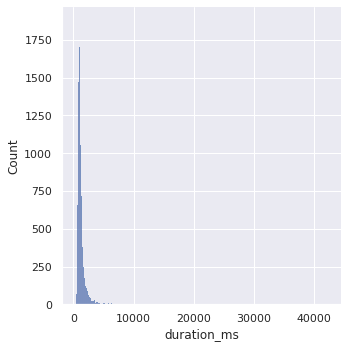

In [16]:
sns.displot(inv_pos_res['duration_ms'])
plt.show()

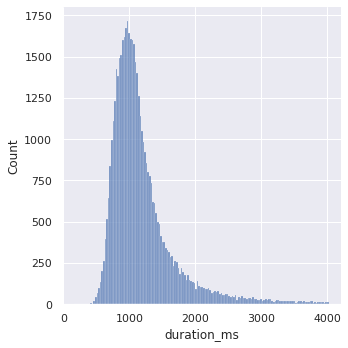

In [17]:
sns.displot(inv_pos_res[inv_pos_res['duration_ms'] < np.percentile(inv_pos_res['duration_ms'], 98)]['duration_ms'])
plt.savefig('figures/inv_pos_times_98.pdf')

At least in terms of annotation times I can't make out any tendencies, the 10 annotators that used invalid tags seem to represent the total set of 22 annotators pretty well, in temrs of annotation times.

In [18]:
inv_n_annotations = n_annotations[n_annotations['vendor_user_id'].isin(invalids['vendor_user_id'])]
inv_n_annotations = inv_n_annotations.rename(columns={'created_at': "n_annotations_inv"})

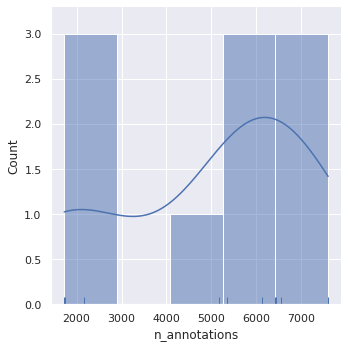

In [19]:
# sns.displot(n_annotations, rug=True, kde=True, stat='count')
sns.displot(inv_n_annotations['n_annotations'], rug=True, kde=True, stat='count')
plt.savefig("figures/inv_n_annotation_hist.pdf")

The only trend I possibly could point out here is, that those annotators who did work on a "medium" number of tasks, betwenn 2000 and 5000 samples did not make use of the invalid flag, but those were pretty few already in the original set and I can't see any reason why exactly those annotators would be more or less likely to use the invalid flag. Therefore my conclusion is that there is no trend in terms of number of annotations.  

In [20]:
ambiguous_tasks = res[res['img_id'].isin(ambiguous.index)]
ambiguous_tasks_by_invalid_users = ambiguous_tasks[ambiguous_tasks['user_id'].isin(inv_users)]


In [21]:
# sns.histplot(n_annotations[n_annotations['vendor_user_id'].isin(invalids['vendor_user_id'])]['created_at'])

## Task 3 Is the reference set balanced?

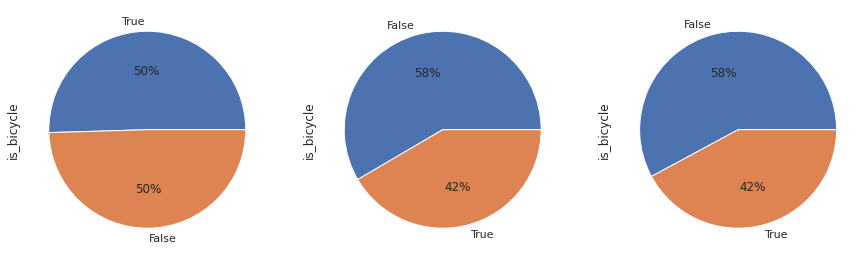

In [22]:
fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,3,1)
tot_balance = ref['is_bicycle'].value_counts()
tot_balance.plot.pie(autopct='%1.0f%%')

fig.add_subplot(1,3,2)
iref = ref.reset_index()
ambiguous_balance = iref[iref['index'].isin(ambiguous.index)]['is_bicycle'].value_counts()
ambiguous_balance.plot.pie(autopct='%1.0f%%')

fig.add_subplot(1,3,3)
highly_ambiguous_balance = iref[iref['index'].isin(highly_ambiguous.index)]['is_bicycle'].value_counts()
highly_ambiguous_balance.plot.pie(autopct='%1.0f%%')

plt.savefig('figures/is_balanced.pdf')
plt.show()

In [23]:
print("counts on total dataset:")
print(tot_balance)
print("------------------------------")
print("counts on ambiguous dataset:")
print(ambiguous_balance)
print("------------------------------")
print("counts on highly ambiguous dataset:")
print(highly_ambiguous_balance)

counts on total dataset:
True     4586
False    4501
Name: is_bicycle, dtype: int64
------------------------------
counts on ambiguous dataset:
False    225
True     160
Name: is_bicycle, dtype: int64
------------------------------
counts on highly ambiguous dataset:
False    114
True      83
Name: is_bicycle, dtype: int64


As we can see above the dataset is pretty balanced as a whole dataset with nearly exactly as much True cases as False cases. If one restricts the dataset to the more difficult cases, it is not as perfect. But considering that we only talk about 385 difficult and 197 highly difficult cases out of 9087 samples the distribution of 58% to 42%  does not seem too bad.

Without any further investigation into what does actually make up the difficult cases, I have to conclude that the dataset is reasonably balanced.

## Task 4 Seperating good from bad annotators.

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

bin_res = res[res['answer'].isin([True, False])]
bin_res['answer'] = bin_res['answer'].astype(bool)


acc = {}
rec = {}
pre = {}
for user in res['vendor_user_id'].unique():
    usr_res = bin_res[bin_res['vendor_user_id']==user]
    acc[user] = accuracy_score(usr_res['is_bicycle'], usr_res['answer'])
    rec[user] = recall_score(usr_res['is_bicycle'], usr_res['answer'])
    pre[user] = precision_score(usr_res['is_bicycle'], usr_res['answer'])


/tmp/ipykernel_41398/3779600097.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_res['answer'] = bin_res['answer'].astype(bool)


In [25]:
s1 = pd.DataFrame.from_dict(acc, orient='index')
s2 = pd.DataFrame.from_dict(pre, orient='index')
s3 = pd.DataFrame.from_dict(rec, orient='index')

stats = pd.DataFrame()
stats['acc'] = s1
stats['rec'] = s2
stats['pre'] = s3

stats = stats.sort_index()

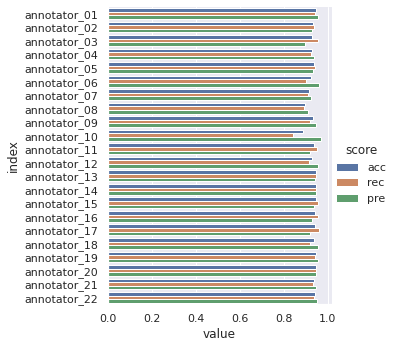

In [26]:
df = stats.reset_index()
df = pd.melt(df, id_vars="index", var_name="score")
sns.catplot(x='value', y='index', hue='score', data=df, kind='bar')
plt.savefig('presentation/figures/summary.pdf')
plt.show()

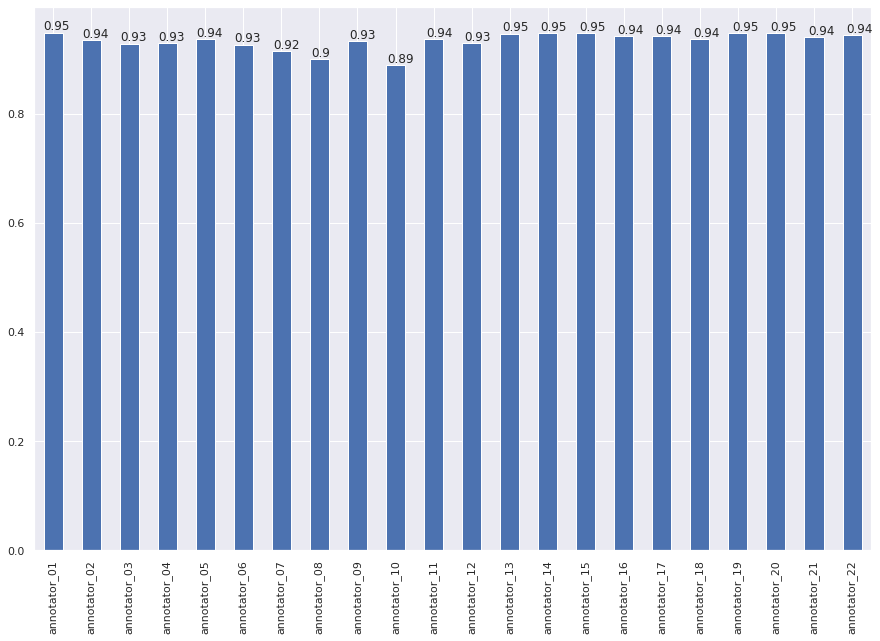

In [27]:
plt.figure(figsize=(15,10))
ax = stats["acc"].plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()


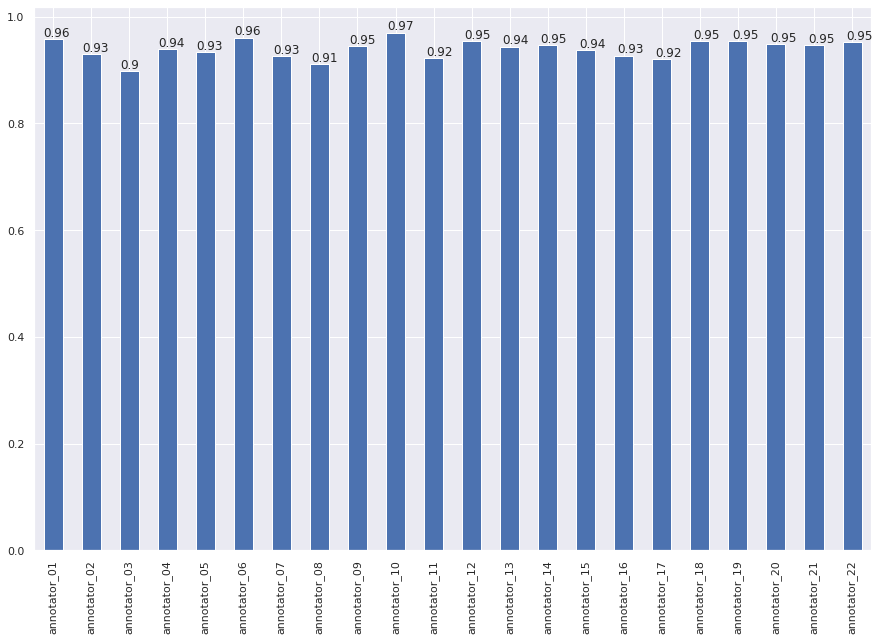

In [28]:
plt.figure(figsize=(15,10))
ax = stats["pre"].plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()


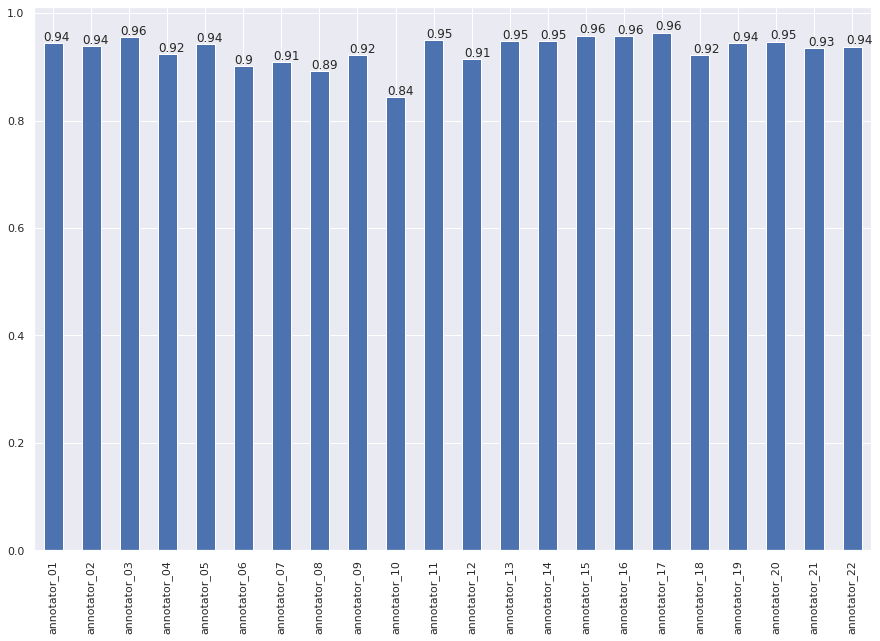

In [29]:
plt.figure(figsize=(15,10))
ax = stats["rec"].plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

In [30]:
best = stats[
    (stats['acc']>= np.percentile(stats['acc'], 50)) &
    (stats['rec']>= np.percentile(stats['rec'], 50)) &
    (stats['pre']>= np.percentile(stats['pre'], 50))
]
best

,acc,rec,pre
annotator_01,0.948438,0.943536,0.957768
annotator_14,0.947216,0.947796,0.946698
annotator_19,0.947059,0.943820,0.954545
annotator_20,0.948408,0.946850,0.949342


As we can see above most annotators are pretty close to each other in terms of accuracy, precision and recall, at least on the total dataset. This is not really surprising since we already saw in the previous sections, that the vast majority of the images is easily identifyable for a human since most annotators agree at the majority of samples. To get a better understanding we have to look at the ambiguous cases.

In [32]:
amb_bin_res = bin_res[bin_res['img_id'].isin(ambiguous.index)]

acc = {}
rec = {}
pre = {}
for user in res['vendor_user_id'].unique():
    usr_res = amb_bin_res[amb_bin_res['vendor_user_id']==user]
    acc[user] = accuracy_score(usr_res['is_bicycle'], usr_res['answer'])
    rec[user] = recall_score(usr_res['is_bicycle'], usr_res['answer'])
    pre[user] = precision_score(usr_res['is_bicycle'], usr_res['answer'])
    
a1 = pd.DataFrame.from_dict(acc, orient='index')
a2 = pd.DataFrame.from_dict(pre, orient='index')
a3 = pd.DataFrame.from_dict(rec, orient='index')

amb_stats = pd.DataFrame()
amb_stats['acc'] = a1
amb_stats['rec'] = a2
amb_stats['pre'] = a3

amb_stats = amb_stats.sort_index()

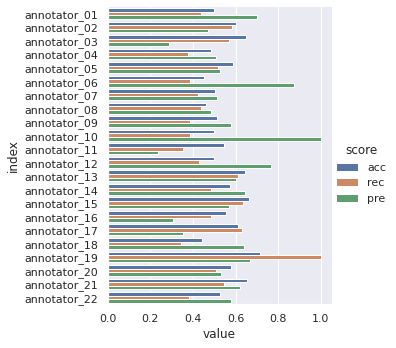

In [33]:
df = amb_stats.reset_index()
df = pd.melt(df, id_vars="index", var_name="score")
sns.catplot(x='value', y='index', hue='score', data=df, kind='bar')
plt.savefig('presentation/figures/amb_summary.pdf')
plt.show()

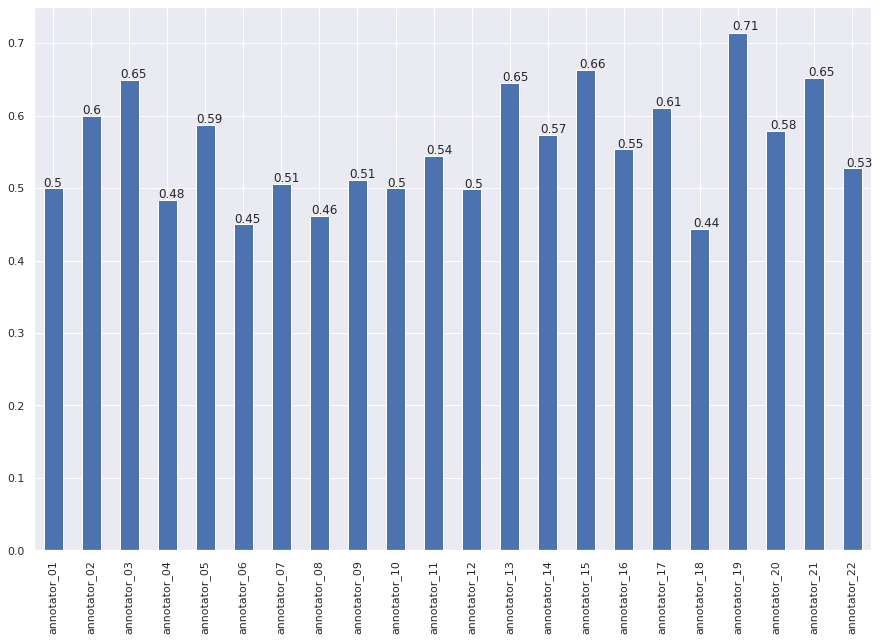

In [34]:
plt.figure(figsize=(15,10))
ax = amb_stats["acc"].plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

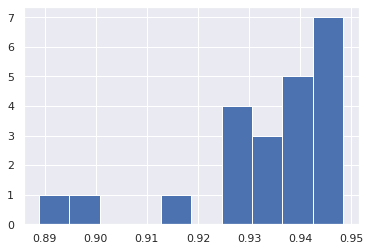

In [35]:
stats['acc'].hist()
plt.show()

Reduced on the more difficult cases accuracies speak a different language only 6 annotators do manage to maintain an accuracy above 60% here.  

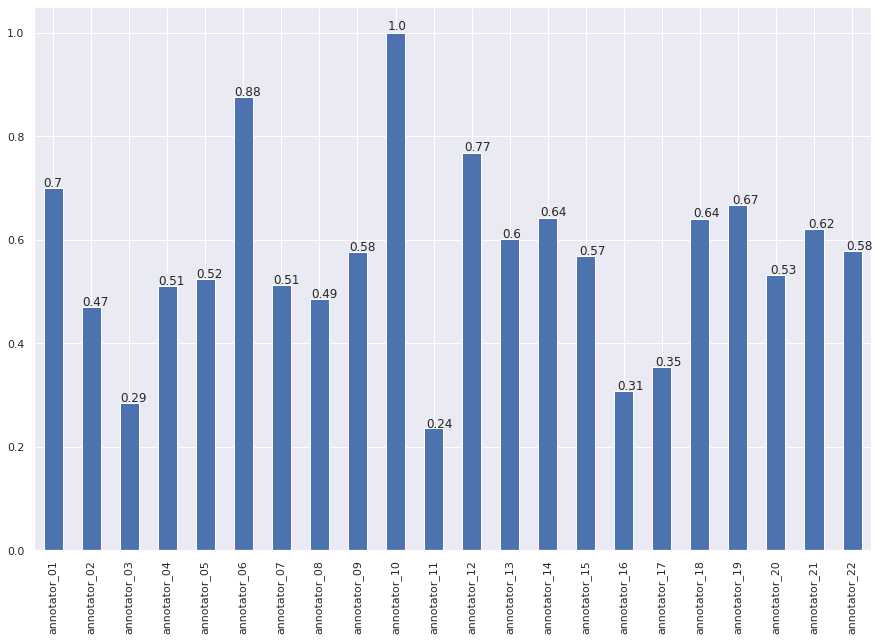

In [36]:
plt.figure(figsize=(15,10))
ax = amb_stats["pre"].plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

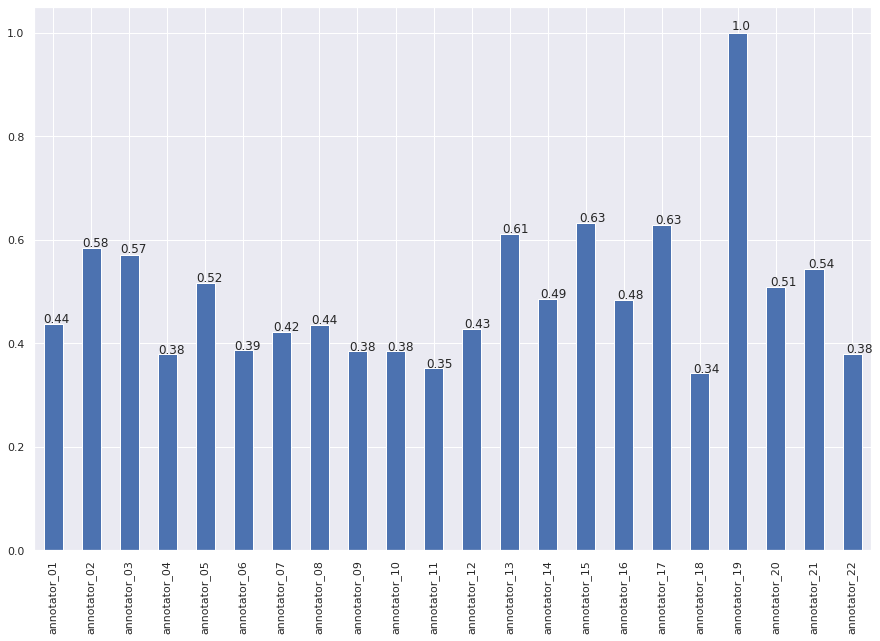

In [37]:
plt.figure(figsize=(15,10))
ax = amb_stats["rec"].plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

In [38]:
best = amb_stats[
    (stats['acc']>= np.percentile(stats['acc'], 50)) &
    (stats['rec']>= np.percentile(stats['rec'], 50)) &
    (stats['pre']>= np.percentile(stats['pre'], 50))
]
best

,acc,rec,pre
annotator_01,0.500000,0.437500,0.700000
annotator_14,0.573529,0.486486,0.642857
annotator_19,0.714286,1.000000,0.666667
annotator_20,0.579151,0.508621,0.531532


In [39]:
answers_by_img['prediction'] = answers_by_img.apply(lambda row: True if row[True] > row[False] else False, axis=1)

In [40]:
accuracy_score(answers_by_img['prediction'], ref['is_bicycle'])

0.952129415648729

I find it surprising that the majority vote is not better.